# Session 3 — Sentence-Level Analysis
## Measure 2: Readability Scores
This notebook computes classic readability formulas for **English** such as:
- Flesch Reading Ease
- Flesch-Kincaid Grade Level

We'll analyze and compare Lewis Carroll's two Alice books:
- Alice's Adventures in Wonderland
- Through the Looking-Glass

In [6]:
import re, os
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# Set plot styles
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# --- Configuration ---
CONFIG = {
    "book1_path": "..\\data\\Fellowship.txt",
    "book2_path": "..\\data\\TwoTowers.txt",
    "book3_path": "..\\data\\TheKing.txt",
    "book1_name": "Fellowship",
    "book2_name": "Two Towers",
    "book3_name": "Return of the King",
}

# Create results directory
Path("../results").mkdir(exist_ok=True)

print("Cell 1: Imports and Config loaded.")

Cell 1: Imports and Config loaded.


In [7]:
# --- Robust Text Loading Functions (from our previous projects) ---
# We use the same functions from Notebook 1 to ensure the
# Foreword/Prologue in Fellowship are correctly stripped.

_GB_START_MARKERS = [
    r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK",
    r"START OF (THIS|THE) PROJECT GUTENBERG EBOOK",
]
_GB_END_MARKERS = [
    r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK",
    r"END OF (THIS|THE) PROJECT GUTENBERG EBOOK",
]
_CHAPTER_HINTS = [
    r"^\s*A LONG-EXPECTED PARTY\s*$", # Start of Fellowship
    r"^\s*The Departure of Boromir\s*$", # Start of Two Towers
    r"^\s*Minas Tirith\s*$", # Start of Return of King
    r"^\s*CHAPTER I\s*$", # Generic fallback
    r"^\s*BOOK I\s*$", # Generic fallback
]

def strip_gutenberg(text: str) -> str:
    """Heuristically strips Gutenberg headers/footers."""
    t = text.replace("\ufeff", "") 
    start_idx, end_idx = None, None
    for pat in _GB_START_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            start_idx = t.find("\n", m.end())
            if start_idx == -1: start_idx = m.end()
            break
    for pat in _GB_END_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            end_idx = m.start()
            break
    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        core = t[start_idx:end_idx]
    else: 
        core = t
        found_start = False
        for pat in _CHAPTER_HINTS:
            m = re.search(pat, core, flags=re.IGNORECASE | re.MULTILINE)
            if m: 
                core = core[m.start():]
                found_start = True
                break
        if found_start:
            for pat in _GB_END_MARKERS:
                 m = re.search(pat, core, flags=re.IGNORECASE)
                 if m:
                     core = core[:m.start()]
                     break
    return core.strip()

def load_text(p: str) -> str:
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def normalize_text(t: str) -> str:
    """Cleans text: strips Gutenberg, normalizes whitespace."""
    t = strip_gutenberg(t)
    # Replace line breaks with spaces, then collapse whitespace
    t = re.sub(r"[\r\n]+", " ", t)
    t = re.sub(r"\s+", " ", t)
    return t

print("Cell 2: Helper functions defined.")

Cell 2: Helper functions defined.


In [8]:
def count_syllables(word):
    """Simple syllable counter for English words"""
    word = word.lower()
    # Remove non-alphabetic characters
    word = re.sub(r'[^a-z]', '', word)
    if not word:
        return 1
    
    # Count vowel groups
    syllables = len(re.findall(r'[aeiouy]+', word))
    
    # Adjust for silent 'e' at the end
    if word.endswith('e') and syllables > 1:
        syllables -= 1
    
    # At least one syllable per word
    return max(1, syllables)

def calculate_readability(text, book_name):
    """Calculate readability scores for a given text"""
    # Split into sentences
    sentences = re.split(r'[.!?]+\s+', text.strip())
    sentences = [s.strip() for s in sentences if s.strip() and len(s.split()) > 2]
    
    # Extract words (alphabetic only)
    words = re.findall(r"[A-Za-z']+", text)
    
    if not sentences or not words:
        print(f"\n{'='*70}\nERROR: No text found for {book_name}. Check stripping.\n{'='*70}")
        return 0, 0, 0, 0
    
    # Count syllables
    syllables = sum(count_syllables(w) for w in words)
    
    num_sentences = len(sentences)
    num_words = len(words)
    
    avg_words_sent = num_words / num_sentences
    avg_syll_word = syllables / num_words
    
    # Flesch Reading Ease
    flesch_ease = 206.835 - 1.015 * (avg_words_sent) - 84.6 * (avg_syll_word)
    
    # Flesch-Kincaid Grade Level
    flesch_grade = 0.39 * (avg_words_sent) + 11.8 * (avg_syll_word) - 15.59
    
    print(f"\n{'='*70}")
    print(f"{book_name}")
    print(f"{'='*70}")
    print(f"Sentences: {num_sentences:,}")
    print(f"Words: {num_words:,}")
    print(f"Syllables: {syllables:,}")
    print(f"Avg words per sentence: {avg_words_sent:.2f}")
    print(f"Avg syllables per word: {avg_syll_word:.2f}")
    
    print(f"\nFlesch Reading Ease: {flesch_ease:.2f}")
    print(f"Flesch-Kincaid Grade Level: {flesch_grade:.2f}")
    
    return flesch_ease, flesch_grade, avg_words_sent, avg_syll_word

print("Cell 3: Readability functions defined.")

Cell 3: Readability functions defined.


In [13]:
# --- Load and Analyze All Three Books ---
print("Loading and cleaning texts...")
text1 = normalize_text(load_text(CONFIG["book1_path"]))
text2 = normalize_text(load_text(CONFIG["book2_path"]))
text3 = normalize_text(load_text(CONFIG["book3_path"]))

print(f"{CONFIG['book1_name']} loaded: {len(text1):,} chars")
print(f"{CONFIG['book2_name']} loaded: {len(text2):,} chars")
print(f"{CONFIG['book3_name']} loaded: {len(text3):,} chars")

# --- Run Analysis ---
# NOTE: The function now returns 4 values: ease, grade, aws, asw
ease1, grade1, aws1, asw1 = calculate_readability(text1, CONFIG["book1_name"])
ease2, grade2, aws2, asw2 = calculate_readability(text2, CONFIG["book2_name"])
ease3, grade3, aws3, asw3 = calculate_readability(text3, CONFIG["book3_name"])

# --- Store results in a DataFrame for easy plotting and saving ---
readability_data = {
    CONFIG['book1_name']: {
        'Flesch Ease': ease1,
        'Flesch Grade': grade1,
        'Avg Words/Sent': aws1,
        'Avg Syll/Word': asw1
    },
    CONFIG['book2_name']: {
        'Flesch Ease': ease2,
        'Flesch Grade': grade2,
        'Avg Words/Sent': aws2,
        'Avg Syll/Word': asw2
    },
    CONFIG['book3_name']: {
        'Flesch Ease': ease3,
        'Flesch Grade': grade3,
        'Avg Words/Sent': aws3,
        'Avg Syll/Word': asw3
    }
}
df_readability = pd.DataFrame(readability_data)

# Save to CSV
df_readability.to_csv("../results/readability_stats.csv")
print("\n\nSuccessfully calculated scores and created df_readability.")

# Display the table
df_readability.T.style.format('{:,.2f}')

Loading and cleaning texts...
Fellowship loaded: 943,442 chars
Two Towers loaded: 817,506 chars
Return of the King loaded: 709,668 chars

Fellowship
Sentences: 10,534
Words: 182,800
Syllables: 235,587
Avg words per sentence: 17.35
Avg syllables per word: 1.29

Flesch Reading Ease: 80.19
Flesch-Kincaid Grade Level: 6.39

Two Towers
Sentences: 10,141
Words: 158,753
Syllables: 202,109
Avg words per sentence: 15.65
Avg syllables per word: 1.27

Flesch Reading Ease: 83.24
Flesch-Kincaid Grade Level: 5.54

Return of the King
Sentences: 7,201
Words: 137,606
Syllables: 174,499
Avg words per sentence: 19.11
Avg syllables per word: 1.27

Flesch Reading Ease: 80.16
Flesch-Kincaid Grade Level: 6.83


Successfully calculated scores and created df_readability.


,Flesch Ease,Flesch Grade,Avg Words/Sent,Avg Syll/Word
Fellowship,80.19,6.39,17.35,1.29
Two Towers,83.24,5.54,15.65,1.27
Return of the King,80.16,6.83,19.11,1.27


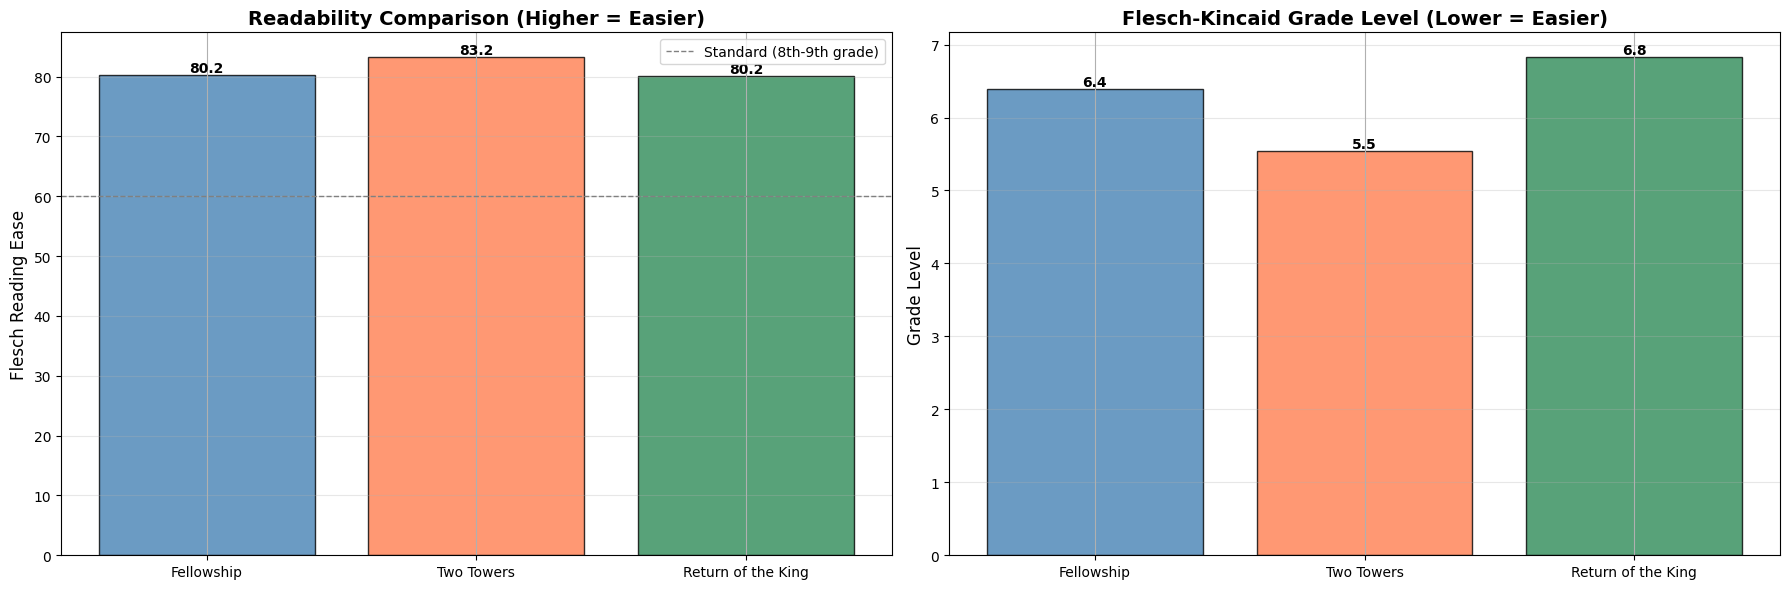


SUMMARY
Analysis complete. All stats and plots saved to ../results/


In [12]:
# Visualize comparison for all 3 books

# Get the data from our DataFrame (created in the previous cell)
labels = df_readability.columns
ease_scores = df_readability.loc['Flesch Ease']
grade_scores = df_readability.loc['Flesch Grade']

x = np.arange(len(labels))  # the label locations

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- Plot 1: Flesch Reading Ease ---
ax1 = axes[0]
colors = ['steelblue', 'coral', 'seagreen']
bars1 = ax1.bar(x, ease_scores, color=colors, edgecolor='black', alpha=0.8)

# Add text for labels, title and axes
ax1.set_ylabel('Flesch Reading Ease', fontsize=12)
ax1.set_title('Readability Comparison (Higher = Easier)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=60, color='gray', linestyle='--', linewidth=1, label='Standard (8th-9th grade)')
ax1.legend()

# Add value labels
ax1.bar_label(bars1, fmt='{:,.1f}', fontsize=10, fontweight='bold')

# --- Plot 2: Flesch-Kincaid Grade Level ---
ax2 = axes[1]
bars2 = ax2.bar(x, grade_scores, color=colors, edgecolor='black', alpha=0.8)

# Add text for labels, title and axes
ax2.set_ylabel('Grade Level', fontsize=12)
ax2.set_title('Flesch-Kincaid Grade Level (Lower = Easier)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
ax2.bar_label(bars2, fmt='{:,.1f}', fontsize=10, fontweight='bold')

plt.tight_layout()
fig.savefig("../results/readability_plots.png", dpi=200, bbox_inches="tight")
plt.show()

# --- Summary ---
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print("Analysis complete. All stats and plots saved to ../results/")